In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import stats, integrate
import os

# Global parameters

In [2]:
data_file = 0


# Data

In [3]:
filename = []

path = '/home/investigator/mariandbt/python/data/'
path = path + '20230327/'

filename.append(os.path.join(path, 'C1--Time-resolution--COMBINED.txt')) 

In [4]:
filename[data_file]

'/home/investigator/mariandbt/python/data/20230327/C1--Time-resolution--COMBINED.txt'

In [5]:
# Oscilloscope
data = []
with open(filename[data_file],'r', encoding='ascii') as fp:
    for i, line in enumerate(fp):
        if any(c.isalpha() for c in line[:7]) == False:
            data.append(np.asarray(line[:-1].split(','), dtype=float))
fp.close()

In [6]:
waveform = np.array(data)

n_points = int(np.where(waveform[:, 0] == waveform[:, 0].max())[0][0] + 1)
n_frames = int(len(waveform)/n_points) 
waveform_saturation = waveform[:, 1].max()

print('n_points = ', n_points)
print('n_frames = ', n_frames)

n_points =  2227
n_frames =  693


# Functions

In [7]:
# Fitting distributions to define

# note: pdf are normilized to 1 so we have yo add an amplitude param
def gauss(x, a,  mu, sigma):
    return a*stats.norm.pdf(x, mu, sigma) 

# Analysis

### Waveform

In [8]:
frame = int(n_frames/2)
frame = 1
frame = 100
frame = int(n_frames) - 1
frame = 500

frame =  500
t_half_peak =  7.44794e-07


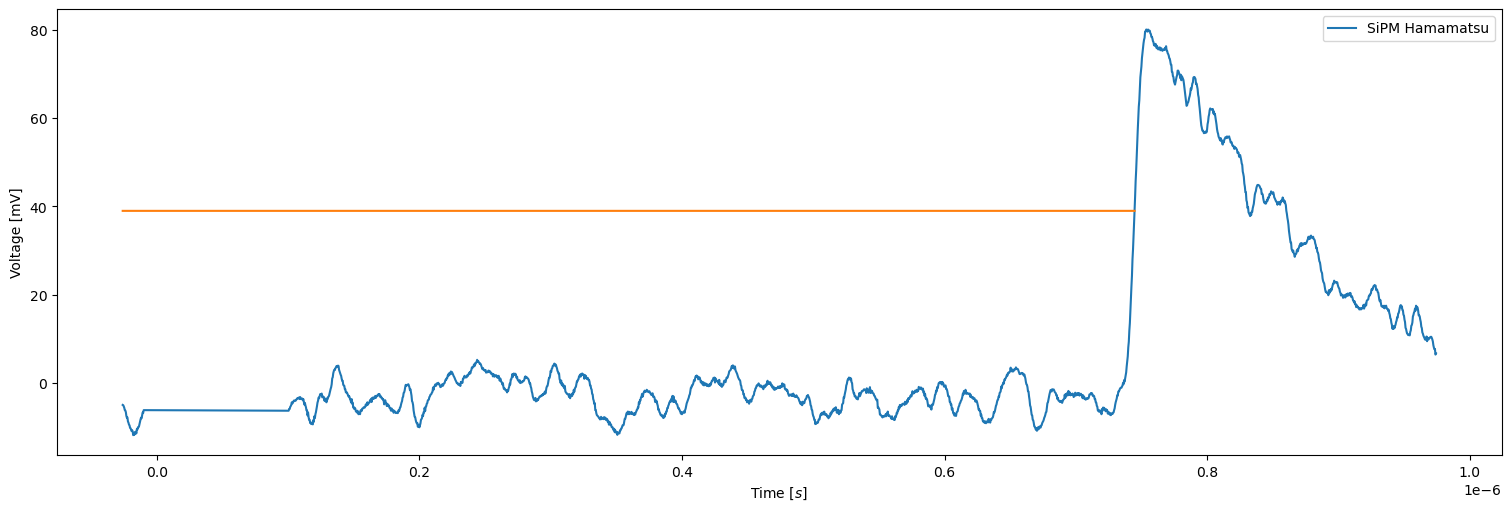

In [9]:
fig, ax = plt.subplots(1, 1, figsize = (15, 5), constrained_layout=True)

print('frame = ', frame)

wave = waveform[frame*n_points: (frame + 1)*n_points].copy()

signal = wave[:, 1]*1e3
t = wave[:, 0]
dt = t[1] - t[0]

mask = np.fabs(signal - (signal.max()/2.)) < 1.55

t_half_peak = t[mask][0]
s_half_peak = signal[mask][0]
print('t_half_peak = ', t_half_peak)

ax.plot(t, signal, label = 'SiPM Hamamatsu')
ax.plot(np.linspace(t.min(), t_half_peak, len(t)), s_half_peak*np.ones(len(t)))

ax.set_ylabel('Voltage [mV]');
ax.set_xlabel('Time [$s$]');
ax.legend(loc = 'best')

(0.85644802, 150.0)

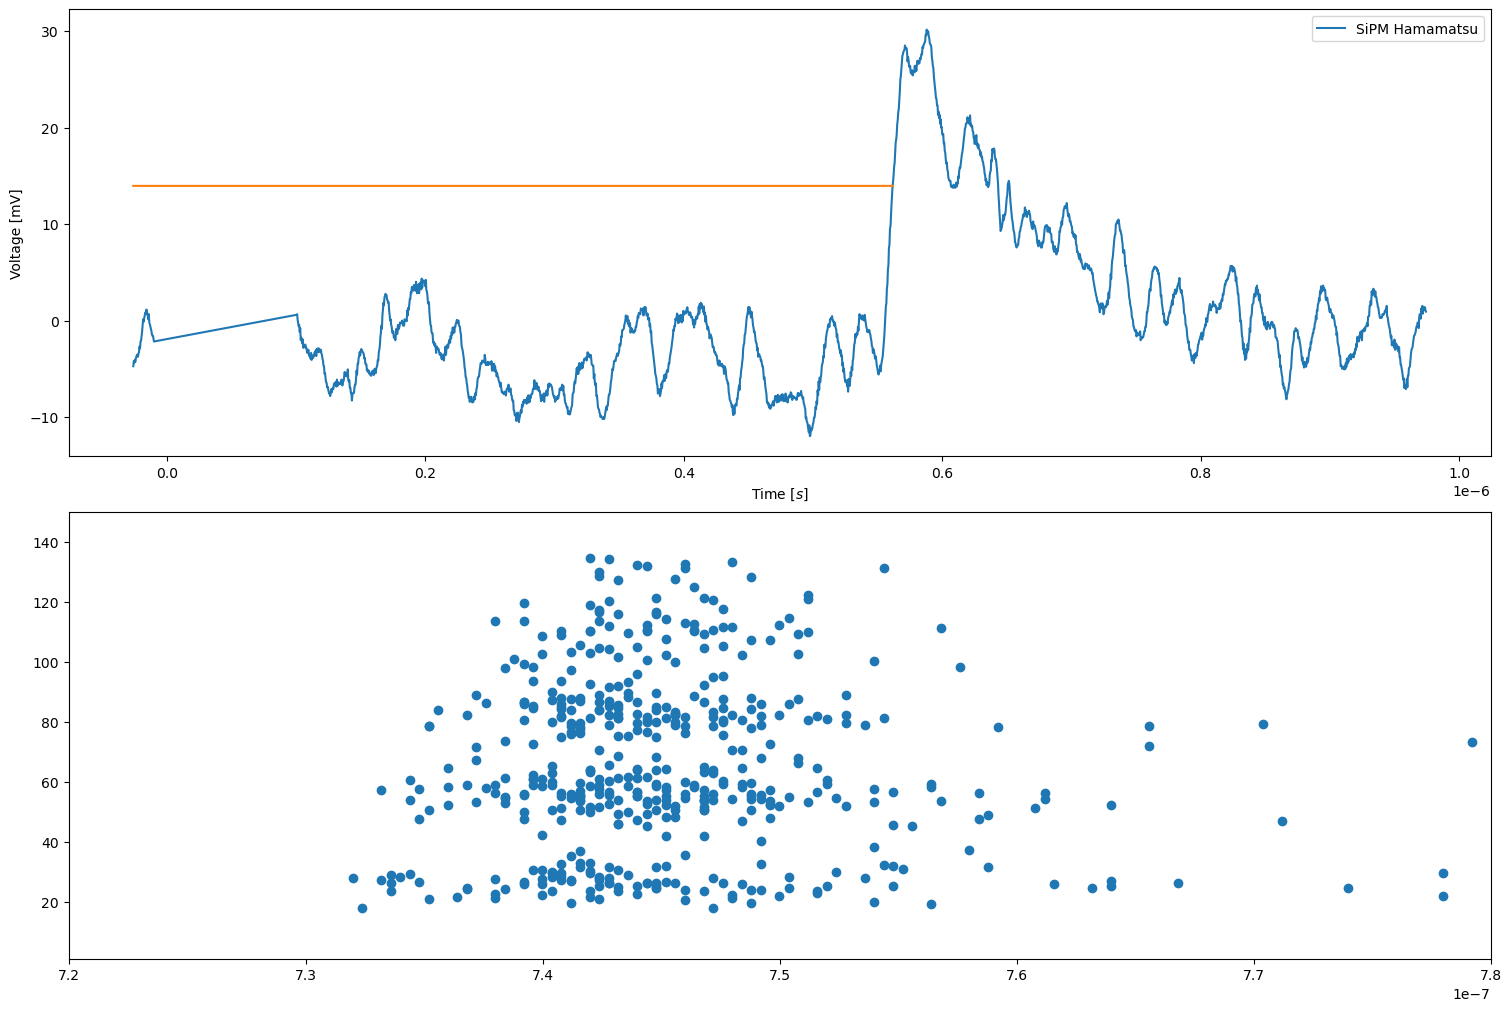

In [10]:
fig, ax = plt.subplots(2, 1, figsize = (15, 10), constrained_layout=True)

t_half_peak = []
s_half_peak = []
s_peak = []

for frame in range(n_frames):
    wave = waveform[frame*n_points: (frame + 1)*n_points].copy()

    if wave[:, 1].max() == waveform_saturation: 
        continue
    
    signal = wave[:, 1]*1e3
    t = wave[:, 0]
    dt = t[1] - t[0]

    mask = np.fabs(signal - signal.max()/2.) < 1.55

    t_half_peak.append(t[mask][0])
    s_half_peak.append(signal[mask][0])

    s_peak.append(signal.max())
    
t_half_peak = np.array(t_half_peak)
s_half_peak = np.array(s_half_peak)
s_peak = np.array(s_peak)
    
#______________________plot settings________________________________________________________

ax[0].plot(t, signal, label = 'SiPM Hamamatsu')
ax[0].plot(np.linspace(t.min(), t_half_peak[-1], len(t)), s_half_peak[-1]*np.ones(len(t)))

ax[0].set_ylabel('Voltage [mV]');
ax[0].set_xlabel('Time [$s$]');
ax[0].legend(loc = 'best')

ax[1].plot(t_half_peak, s_peak, 'o')
ax[1].set_xlim([7.2e-7, 7.8e-7])
ax[1].set_ylim([s_peak.min(), 150])


### Time & energy resolutions calculation

#### Peaks energy determination

We need to separate the time information for different peaks 

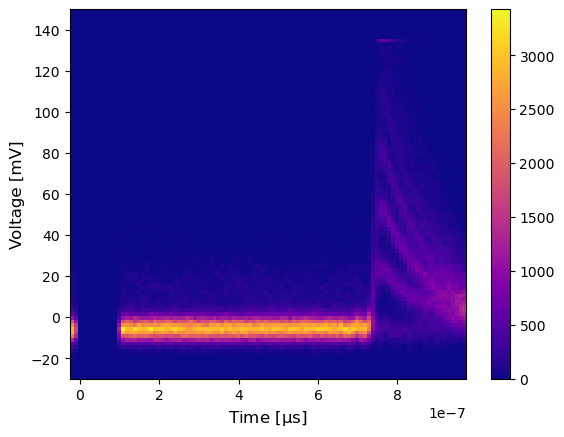

In [11]:
from matplotlib import colors
import copy

fig, ax = plt.subplots(1,1)
# my_cmap = copy.copy(colormaps['plasma']) # copy the default cmap
# my_cmap.set_bad(my_cmap.colors[0])

counts, xedges, yedges, im = ax.hist2d(np.hstack(waveform[:, 0]), np.hstack(waveform[:, 1])*1000, 
                                       bins=100,# rasterized=True, 
                                       range=((waveform[:, 0].min(),waveform[:, 0].max()), (-30,150)), 
#                                        cmap='plasma', norm=colors.LogNorm(), cmin = 0)
                                       cmap='plasma', vmin = 0)

# im.set_cmin(1)

ax.set_xlabel(r"Time [$\mathrm{\mu}$s]", size='larger')
ax.set_ylabel("Voltage [mV]", size='larger')

fig.colorbar(im, ax = ax, orientation='vertical')
# fig.savefig("waveforms.pdf")

In [12]:
signal_1pe = 20 # [mV]
signal_2pe = 55 # [mV]
signal_3pe = 80 # [mV]
signal_4pe = 110 # [mV]


In [13]:
signal_pe = [s_peak.min(), signal_1pe, signal_2pe, signal_3pe, signal_4pe, s_peak.max()] # [mV]
# signal_pe = [20, 60, 80, 110] # [mV]

n_pe = len(signal_pe) - 2 # to remove the 2 extremes

# dV = [s_peak.min()] # [mV]
dV = [] # [mV]

# for i in range(1, n_pe+1):
for i in range(0, n_pe+1):
    dV.append((signal_pe[i+1] + signal_pe[i])/2)
    
dV.append(s_peak.max())
    
mask_pe = []
for i in range(n_pe+1):
#     mask_pe.append(np.fabs(s_peak - signal_pe[i]) <= dV) # for fixed dV
    
    mask_pe.append(((s_peak > dV[i]) & (s_peak < dV[i+1])))
        

#### Peaks separation

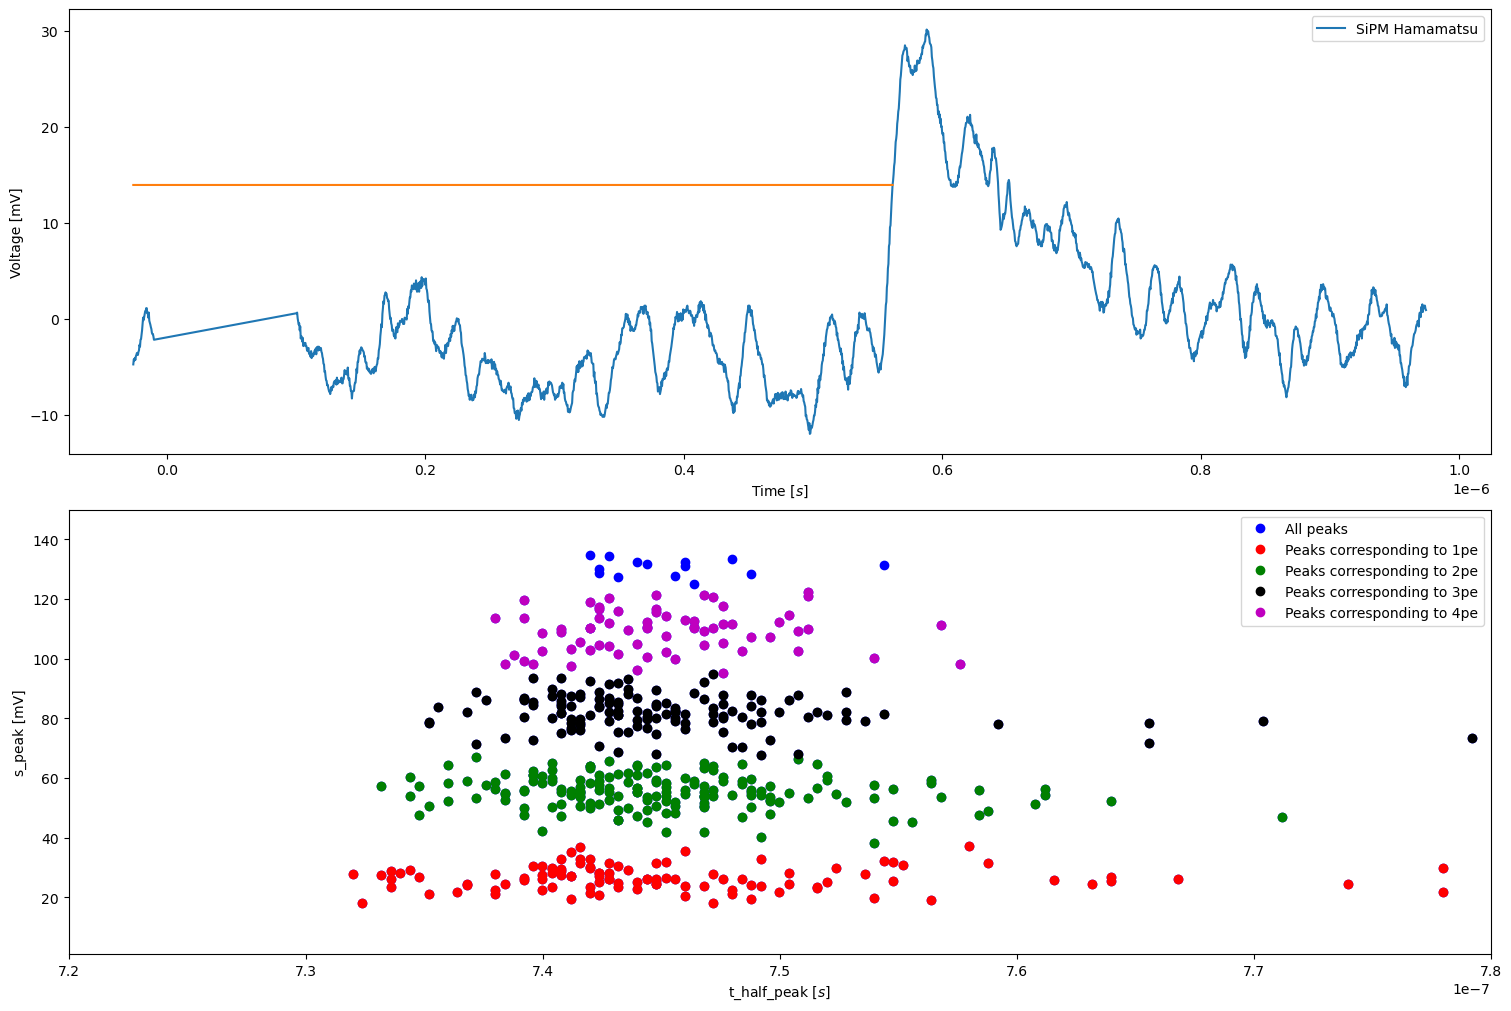

In [14]:
fig, ax = plt.subplots(2, 1, figsize = (15, 10), constrained_layout=True)

t_half_peak = []
s_half_peak = []
s_peak = []

for frame in range(n_frames):
    wave = waveform[frame*n_points: (frame + 1)*n_points].copy()

    if wave[:, 1].max() == waveform_saturation: 
        continue
    
    signal = wave[:, 1]*1e3
    t = wave[:, 0]
    dt = t[1] - t[0]

    mask = np.fabs(signal - signal.max()/2.) < 1.55

    t_half_peak.append(t[mask][0])
    s_half_peak.append(signal[mask][0])

    s_peak.append(signal.max())
    
t_half_peak = np.array(t_half_peak)
s_half_peak = np.array(s_half_peak)
s_peak = np.array(s_peak)
    
#______________________plot settings________________________________________________________

ax[0].plot(t, signal, label = 'SiPM Hamamatsu')
ax[0].plot(np.linspace(t.min(), t_half_peak[-1], len(t)), s_half_peak[-1]*np.ones(len(t)))

ax[0].set_ylabel('Voltage [mV]');
ax[0].set_xlabel('Time [$s$]');
ax[0].legend(loc = 'best')

ax[1].plot(t_half_peak, s_peak, 'ob', label = 'All peaks')
ax[1].plot(t_half_peak[mask_pe[0]], s_peak[mask_pe[0]], 'or', label = 'Peaks corresponding to 1pe')
ax[1].plot(t_half_peak[mask_pe[1]], s_peak[mask_pe[1]], 'og', label = 'Peaks corresponding to 2pe')
ax[1].plot(t_half_peak[mask_pe[2]], s_peak[mask_pe[2]], 'ok', label = 'Peaks corresponding to 3pe')
ax[1].plot(t_half_peak[mask_pe[3]], s_peak[mask_pe[3]], 'om', label = 'Peaks corresponding to 4pe')

ax[1].set_ylabel('s_peak [mV]');
ax[1].set_xlabel('t_half_peak [$s$]');

ax[1].set_xlim([7.2e-7, 7.8e-7])
ax[1].set_ylim([s_peak.min(), 150])
ax[1].legend(loc = 'best')


#### Time resolution calculation

In [15]:
1%2
for pe in range(10):
    print((pe*(pe-1)/2.)%2)

0.0
0.0
1.0
1.0
0.0
0.0
1.0
1.0
0.0
0.0


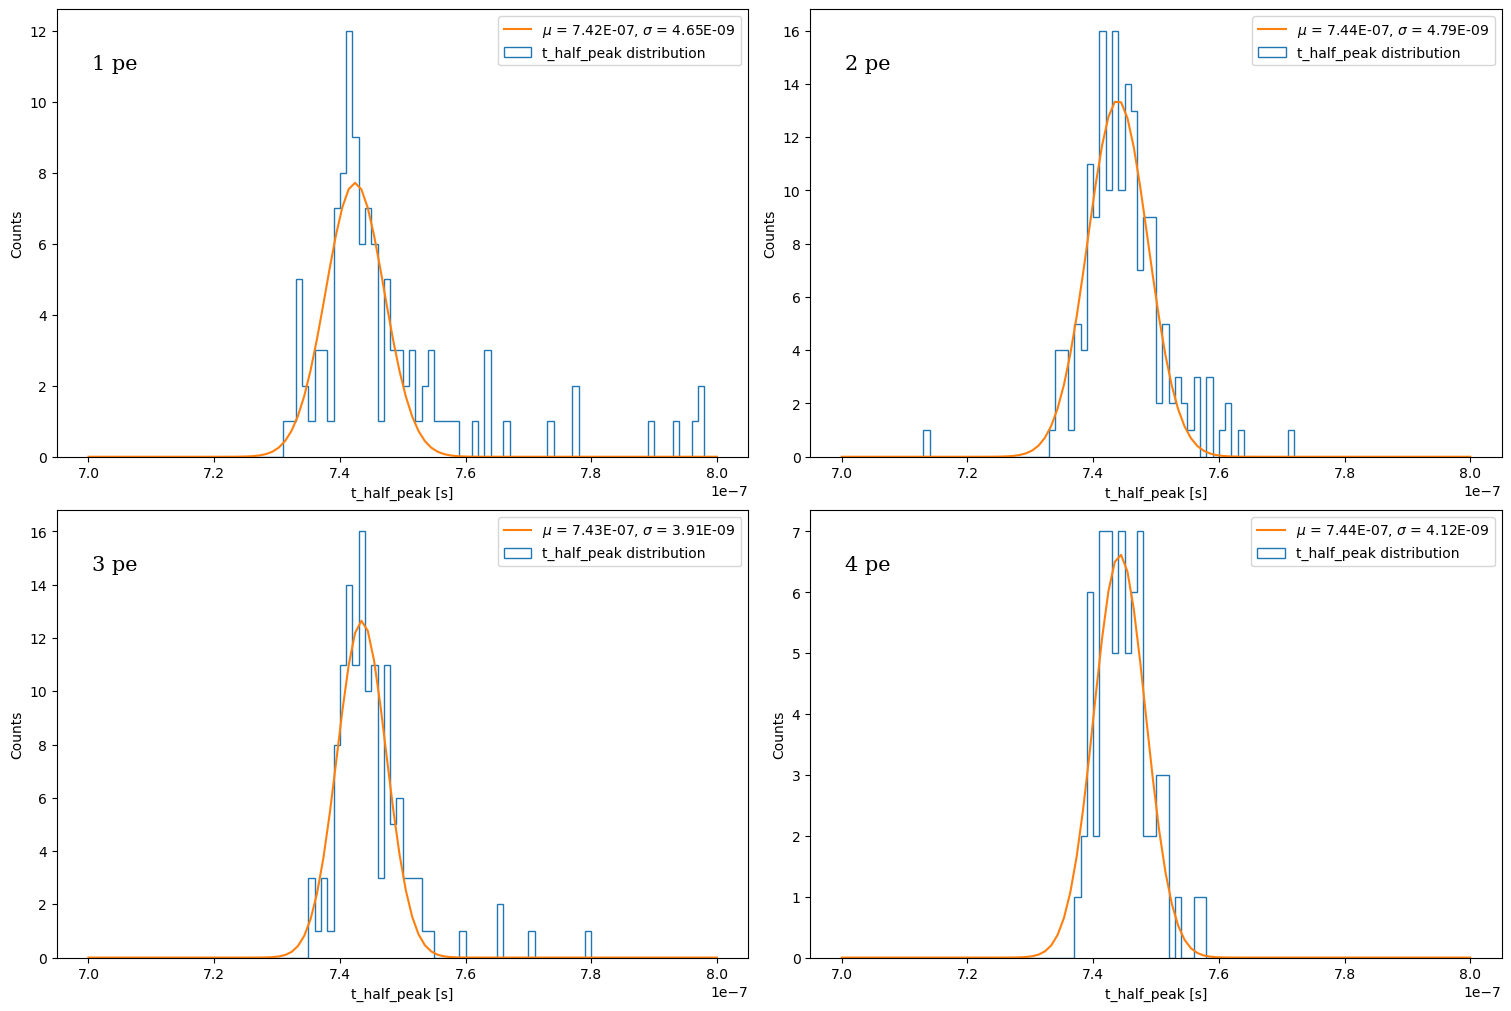

In [16]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10), constrained_layout=True)

for pe in range(n_pe):
    n_row = int((pe*(pe-1)/2.)%2) # 0,0,1,1,0,0...
    n_col = int((1 + (-1)**(pe + 1))/2.) #0,1,0,1,0,1...
    
    events, bins, bars = ax[n_row, n_col].hist(t_half_peak[mask_pe[pe]], 100, 
                                     density=False, range=(7e-7, 8e-7),
                                     label='t_half_peak distribution', 
                                     histtype='step')
    x_ax = np.linspace(bins.min(), bins.max(), len(bins)-1)

    # gaussian fit

#     popt, pcov = scipy.optimize.curve_fit(gauss, x_ax, events, bounds=([0, 0, 0], [2, 1e-6, 1e-6])) 
#     popt, pcov = scipy.optimize.curve_fit(gauss, x_ax, events, p0=[1, bins.mean(), 1e2]) 
    popt, pcov = scipy.optimize.curve_fit(gauss, x_ax, events, p0=[1.5e-7, 7.5e-7, 7e-9]) 

    a, mu, sigma = popt
    best_fit_line = gauss(x_ax, a, mu, sigma)

    #_________plot_settings_________________________________________________

    ax[n_row, n_col].plot(x_ax, gauss(x_ax, a, mu, sigma), '-', label='$\mu$ = %.2E, $\sigma$ = %.2E'%(mu, sigma))
    
    ax[n_row, n_col].text(0.05, .9, str(pe+1) + ' pe', transform=ax[n_row, n_col].transAxes,
                fontsize=15, verticalalignment='top', fontfamily='serif',
                bbox=dict(facecolor='1.', edgecolor='none', pad=3.0))

    ax[n_row, n_col].set_ylabel('Counts')
    ax[n_row, n_col].set_xlabel('t_half_peak [s]')

    ax[n_row, n_col].legend(fontsize=10, loc='best')

#     print('n_pe = ', pe)
#     print('Amplification = ', '%.2E'%(a))
#     print('Mean value = ', '%.2E'%(mu))
#     print('Std = %.2E \n'%(sigma))


#### Energy resolution calculation

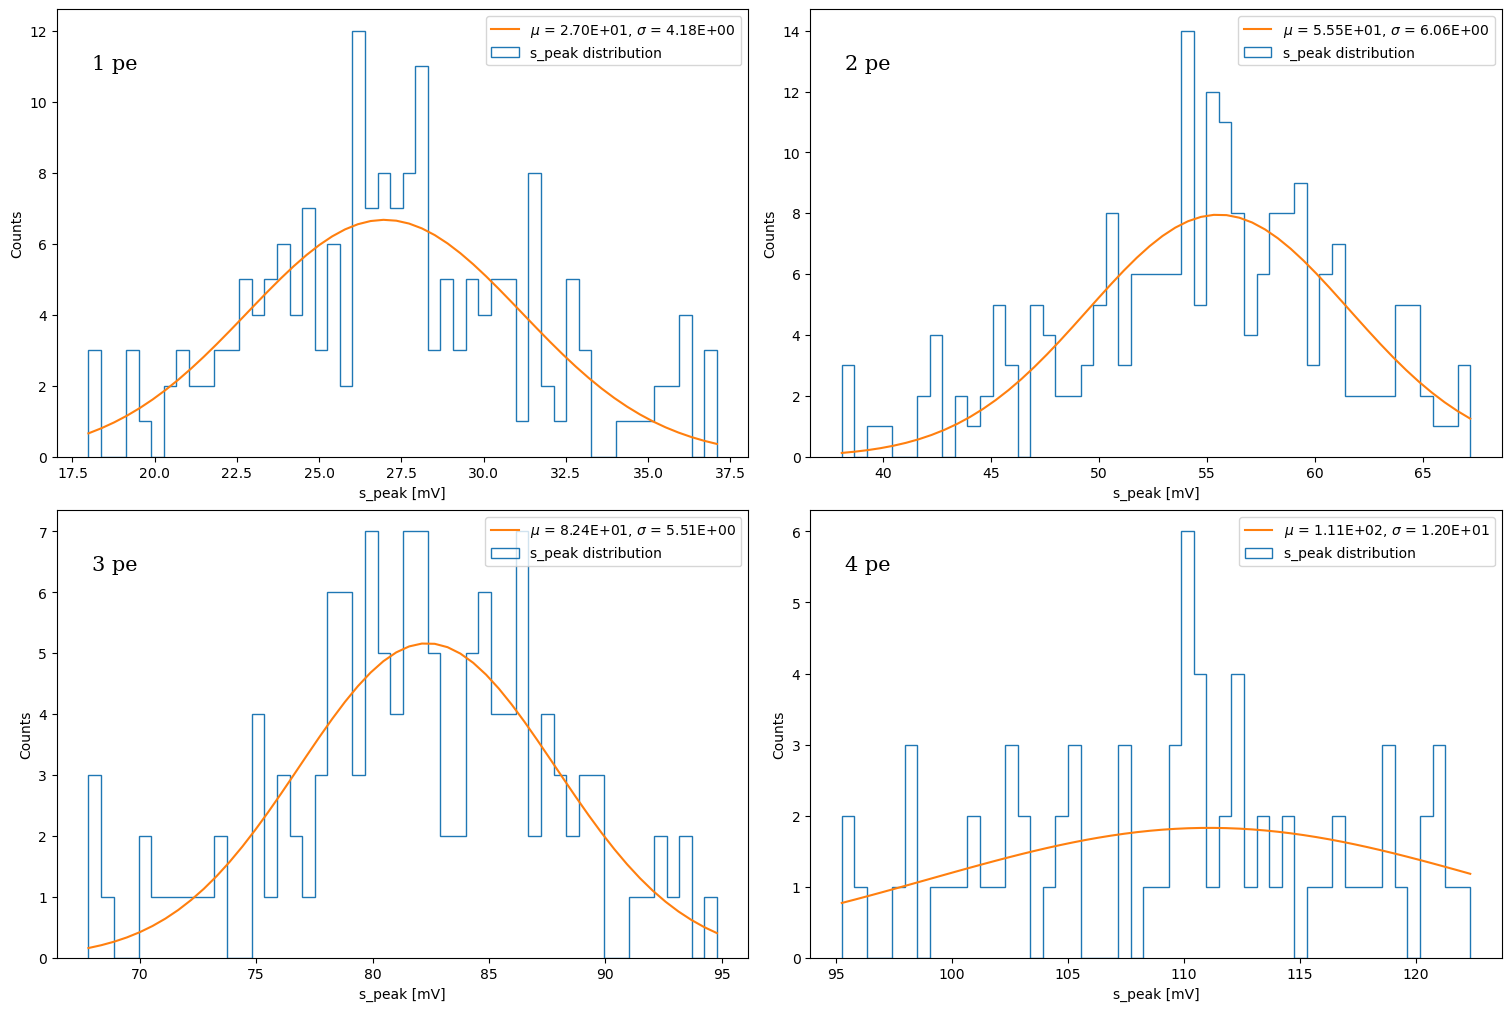

In [17]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10), constrained_layout=True)

for pe in range(n_pe):
    n_row = int((pe*(pe-1)/2.)%2) # 0,0,1,1,0,0...
    n_col = int((1 + (-1)**(pe + 1))/2.) #0,1,0,1,0,1...
    
    events, bins, bars = ax[n_row, n_col].hist(s_peak[mask_pe[pe]], 50, 
                                     density=False, #range=(7e-7, 8e-7),
                                     label='s_peak distribution', 
                                     histtype='step')
    x_ax = np.linspace(bins.min(), bins.max(), len(bins)-1)

    # gaussian fit

#     popt, pcov = scipy.optimize.curve_fit(gauss, x_ax, events, bounds=([0, 0, 0], [2, 1e-6, 1e-6])) 
    popt, pcov = scipy.optimize.curve_fit(gauss, x_ax, events, p0=[1, bins.mean(), 1e2]) 
#     popt, pcov = scipy.optimize.curve_fit(gauss, x_ax, events, p0=[1.5e-7, 7.5e-7, 7e-9]) 

    a, mu, sigma = popt
    best_fit_line = gauss(x_ax, a, mu, sigma)

    #_________plot_settings_________________________________________________

    ax[n_row, n_col].plot(x_ax, gauss(x_ax, a, mu, sigma), '-', label='$\mu$ = %.2E, $\sigma$ = %.2E'%(mu, sigma))
    
    ax[n_row, n_col].text(0.05, .9, str(pe+1) + ' pe', transform=ax[n_row, n_col].transAxes,
                fontsize=15, verticalalignment='top', fontfamily='serif',
                bbox=dict(facecolor='1.', edgecolor='none', pad=3.0))

    ax[n_row, n_col].set_ylabel('Counts')
    ax[n_row, n_col].set_xlabel('s_peak [mV]')

    ax[n_row, n_col].legend(fontsize=10, loc='best')

#     print('n_pe = ', pe)
#     print('Amplification = ', '%.2E'%(a))
#     print('Mean value = ', '%.2E'%(mu))
#     print('Std = %.2E \n'%(sigma))
